<a href="https://colab.research.google.com/github/DiploDatos/AprendizajeProfundo/blob/master/8_automated_hyperparameter_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Búsqueda de Hiperparámetros

Las redes neuronales tienen decenas de hiperparámetros que afectan su arquitectura y proceso de entrenamiento. Más aún, el desempeño final del modelo está condicionado a encontar un conjunto de valores para dichos hiperparámetros exitosos, para una inicialización aleatoria de los pesos dada. Por ello, la exploración de hiperparámetros se vuelve una de las partes más tediosas y críticas del entrenamiento de redes neuronales. Para obtener resultados que sean correctos, significativos y reproducibles es necesario planificar y sistemizar este proceso de búsqueda.

  >  hyper-parameter optimization should be regarded as a formal outer loop in the learning process

Formalmente, este proceso se puede describir como la minimización de la función de pérdida (o maximizar la performance) como si fuera una función de *caja negra* que toma como parámetros los valores de los hiperparámetros:

$$ f(\theta) = loss_\theta(y, \hat{y}) $$
$$ \theta^* = argmin_\theta f(\theta) $$

donde $\theta$ es el conjunto de hiperparámetros del modelo, $loss$ es la pérdida generada entre las etiquetas verdaderas $y$ y las etiquetas generadas por el modelo $\hat{y}$, y $f$ es la función objetivo de la minimización.


Las estrategias principales para la exploración del espacio de hiperparámetros son:
* Búsqueda manual, donde un humano define los valores de cada hiperparámetro.
* Búsqueda por grilla o *grid search*, donde se define un conjunto de valores posibles que puede tomar cada hiperparámetro, y se realiza un experimento por cada combinación posible.
* Búsqueda aleatoria o *random search*, donde se define un rango de valores posibles para cada hiperparámetro, y se elige al azar un valor del rango para cada experimento.
* Búsqueda automátizada, *automated search* o *model-based search*, que es igual a la búsqueda aleatoria pero la selección del valor de cada hiperparámetro está condicionado por los resultados de experimentos anteriores. Para más información ver el paper [*Algorithms for Hyper-Parameter Optimization*](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)

En la siguiente imagen, tomada del paper [*Random Search for Hyper-Parameter Optimization*](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf), se muestra el impacto de las primeras dos estrategias para un hiperparámetro con alta influencia en el desempeño del modelo final, y otro que sin influencia. No solo require muchas evaluaciones para lograr cobertura, sino que las combinaciones en dónde sólo se varían hiperparámetros no relevantes no recolectan información nueva. El éxito de la búsqueda por grilla depende de que el nivel de granularidad de la grilla cubra adecuadamente los valores relevantes, que son desconocidos a priori.

![Comparación de las exploraciones entre grid search y random search](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1531340388/grid_vs_random_jltknd.png)


Para solucionar todos estos problemas, es que se utiliza la **exploración bayesiana**. Este método modela la loss como un Gaussian process, y tiene en cuenta los resultados de los experimentos anteriores para ir construyendo una distribución de probabilidad de la pérdida dados los hiperparámetros:

$$ P(loss | \theta)$$

Para elegir una nueva combinación de hiperparámetros a probar dados los experimentos previos, el algoritmo utiliza una *surrogate function* para aproximar el comportamiento de la pérdida y una *selection function* basada en la mejora esperada. A grandes rasgos, el algoritmo sigue los siguientes pasos:

  1. Encontrar el mejor conjunto de hiperparámetros que maximize la mejora esperada (EI), estimada a través de la *surrogate function*.
  2. Calcular la performance del modelo con la combinación de hiperparámetros elegida. Esto corresponde a evaluar la función objetivo.
  3. Actualizar la forma de la *surrogate function* utilizando el teorema de Bayes para que se ajuste mejor a la verdadera distribución $ P(loss | \theta)$

Afortunadamente, muchos algoritmos de búsqueda están implementados y funcionan como cajas negras. Veremos un ejemplo utilizando la librería hyperopt

In [35]:
# If running in colab, you need to update gensim
# !pip install --upgrade gensim

In [36]:
import csv
import functools
import gzip
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import tempfile
import seaborn


from gensim import corpora
from gensim.models import KeyedVectors
from gensim.parsing import preprocessing
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm.notebook import tqdm, trange


In [37]:
# Ensure version 4.X
import gensim
gensim.__version__

'4.1.2'

## Parte 1: Preprocesamiento del texto

Primero leeremos el dataset como se explica en la notebook 5_cnns.ipynb.

In [38]:
# If necessary, download data
# %%bash
# mkdir data
# curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
# curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/imdb_reviews.csv.gz -o ./data/imdb_reviews.csv.gz

In [39]:
class IMDBReviewsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "review"],
            "target": self.dataset.loc[item, "sentiment"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        self.dictionary = corpora.Dictionary(
            dataset["review"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary and compactify it (make the indices continous)
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        self.dictionary.compactify()
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["sentiment"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}

    def _preprocess_string(self, string):
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target,
            "sentence": item["data"]
        }

### Separando el conjunto de validación o *dev*

En deep learning, es **MUY** importante utilizar un conjunto de validación durante la búsqueda de hiperparámetros, que puede ser tomado de la partición de entrenamiento. Esto es independiente de la estrategia de búsqueda que se utilice.

De esta manera, se previene el overfitting indirecto y se cuenta con una partición de datos nunca antes vista para poder evaluar la generalización real del modelo a datos no vistos.


In [40]:
dataset = pd.read_csv("./data/imdb_reviews.csv.gz")
preprocess = RawDataProcessor(dataset)
train_indices, test_indices = train_test_split(dataset.index, test_size=0.2, random_state=42)
train_indices, dev_indices = train_test_split(train_indices, test_size=0.2, random_state=42)
train_dataset = IMDBReviewsDataset(dataset.loc[train_indices].reset_index(drop=True), transform=preprocess)
dev_dataset = IMDBReviewsDataset(dataset.loc[dev_indices].reset_index(drop=True), transform=preprocess)
# We won't use test_dataset until the end!
test_dataset = IMDBReviewsDataset(dataset.loc[test_indices].reset_index(drop=True), transform=preprocess)

In [41]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=100):
        self.pad_value = pad_value
        self.max_length = max_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        max_length = self.max_length
        seq_lengths = [min(self.max_length, l) for l in seq_lengths]

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

## Parte 2: Esqueleto de la red neuronal

Definimos el modelo a entrenar.

In [42]:
import torch
import torch.nn as nn

In [60]:
class ImdbLSTM(nn.Module):
    def __init__(self,
                 pretrained_embeddings_path, dictionary, embedding_size,
                 hidden_layer=32,
                 num_layers=1, dropout=0., bias=True,
                 bidirectional=False,
                 freeze_embedings=True):
        
        super(ImdbLSTM, self).__init__()
        output_size = 1
        # Create the Embeddings layer and add pre-trained weights
        embeddings_matrix = torch.randn(len(dictionary), embedding_size)
        embeddings_matrix[0] = torch.zeros(embedding_size)
        with gzip.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embedding_config = {'freeze': freeze_embedings,
                                  'padding_idx': 0}
        self.embeddings = nn.Embedding.from_pretrained(
            embeddings_matrix, **self.embedding_config)
        
        # Set our LSTM parameters
        self.lstm_config = {'input_size': embedding_size,
                            'hidden_size': hidden_layer,
                            'num_layers': num_layers,
                            'bias': bias,
                            'batch_first': True,
                            'dropout': dropout if num_layers > 1 else 0.0,
                            'bidirectional': bidirectional}
        
        # Set our fully connected layer parameters
        self.linear_config = {'in_features': hidden_layer,
                              'out_features': output_size,
                              'bias': bias}
        
        # Instanciate the layers
        self.lstm = nn.LSTM(**self.lstm_config)
        self.droupout_layer = nn.Dropout(dropout)
        self.classification_layer = nn.Linear(**self.linear_config)
        self.activation = nn.Sigmoid()

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        lstm_out, _ = self.lstm(emb)
        # Take last state of lstm, which is a representation of
        # the entire text
        lstm_out = lstm_out[:, -1, :].squeeze()
        lstm_out = self.droupout_layer(lstm_out)
        predictions = self.activation(self.classification_layer(lstm_out))
        return predictions

Encapsularemos el algoritmo de entrenamiento dentro de una función parametrizable. La función debería devolver los resultados obtenidos.

In [61]:
# Some default values
EPOCHS = 2
MAX_SEQUENCE_LEN = 100

In [62]:
import torch.optim as optim

def train_imbd_model(train_dataset, dev_dataset,
                     pretrained_embeddings_path, dictionary, embedding_size,
                     batch_size=128, max_sequence_len=MAX_SEQUENCE_LEN,
                     hidden_layer=32, dropout=0.,
                     epochs=EPOCHS, lr=0.001, optimizer_class=optim.Adam,
                     verbose=False):

    if verbose:
        print_fn = print
    else:
        print_fn = lambda *x: None
    # We define again the data loaders since this code could run in
    # parallel
    pad_sequeces = PadSequences(max_length=max_sequence_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=pad_sequeces, drop_last=False)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False,
                            collate_fn=pad_sequeces, drop_last=False)

    # We are not going to explore all hyperparameters, only this ones.
    model = ImdbLSTM(pretrained_embeddings_path, dictionary, embedding_size,
                     hidden_layer=hidden_layer, dropout=dropout)

    loss_function = nn.BCELoss()
    optimizer = optimizer_class(model.parameters(), lr)

    history = {
        'train_loss': [],
        'test_loss': [],
        'test_avp': []
    }
    for epoch in range(epochs):
        model.train()
        running_loss = []
        print_fn("Epoch", epoch)
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(batch["data"])
            loss_value = loss_function(output.squeeze(), batch["target"])
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())
        train_loss = sum(running_loss) / len(running_loss)
        print_fn("\t Final train_loss", train_loss)
        history['train_loss'].append(train_loss)
        
        model.eval()
        running_loss = []
        targets = []
        predictions = []
        for batch in dev_loader:
            output = model(batch["data"])
            running_loss.append(
                loss_function(output.squeeze(), batch["target"]).item()
            )
            targets.extend(batch["target"].numpy())
            # Round up model output to get the predictions.
            # What would happen if you change the activation to tanh?
            predictions.extend(output.squeeze().round().detach().numpy())
        test_loss = sum(running_loss) / len(running_loss)
        avp = metrics.average_precision_score(targets, predictions)
        print_fn("\t Final test_loss", test_loss)
        print_fn("\t Final test_avp", avp)
        history['test_loss'].append(test_loss)
        history['test_avp'].append(avp)
    return history

In [63]:
history = train_imbd_model(
    train_dataset, dev_dataset,
    pretrained_embeddings_path="./data/glove.6B.50d.txt.gz",
    dictionary=preprocess.dictionary, embedding_size=50, verbose=True)

Epoch 0
	 Final train_loss 0.6751024463176727
	 Final test_loss 0.61183714488196
	 Final test_avp 0.6281198166028745
Epoch 1
	 Final train_loss 0.633317717552185
	 Final test_loss 0.6387771065272982
	 Final test_avp 0.606606246189802


## Utilizando hyperopt

Para utilizar alguno de los algoritmos de hyperopt, es necesario definir una función objetivo que será minimizada. Esta función recibe un objeto con los valores para los hiperparámetros de cada experimento, y debe devolver una única métrica (o un diccionario con la clave `key` asociada a dicha métrica). En nuestro caso, utilizaremos el *average precision score* obtenido en el conjunto de validación.

Les recomendamos consultar el [Tutorial oficial](https://github.com/hyperopt/hyperopt/wiki/FMin) para más detalles.

In [78]:
from hyperopt import STATUS_OK
# define an objective function
def objective_fn(args):
    print("Exploring config:", args)
    # These references a train_dataset and dev_dataset are
    # taken from the globa context!
    history = train_imbd_model(
        train_dataset, dev_dataset,
        pretrained_embeddings_path="./data/glove.6B.50d.txt.gz",
        dictionary=preprocess.dictionary, embedding_size=50,
        **args)

    # This is the value that will be minimized!
    history['loss'] = history['test_avp'][-1] * -1
    # These are required keys
    history['status'] = STATUS_OK
    
    return history

In [79]:
from hyperopt import hp, fmin, tpe, Trials

# define a search space
space = {
    'lr': hp.loguniform('lr', numpy.log(0.0001), numpy.log(0.005)),  # see appendix
    'optimizer_class': hp.choice(
        'optimizer_class', [optim.Adam, optim.RMSprop]),
    'dropout': hp.uniform('dropout', 0, 0.5)
}

# define the Trials object, which will allow us to store
# information from every experiment.
trials = Trials()
# minimize the objective over the space
best = fmin(objective_fn, space, algo=tpe.suggest, max_evals=10, trials=trials)

Exploring config:
{'dropout': 0.2890479374892883, 'lr': 0.0005619877136798918, 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>}
Exploring config:
{'dropout': 0.22131831673195007, 'lr': 0.0035044337243026304, 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>}
Exploring config:
{'dropout': 0.16934105885114742, 'lr': 0.0012099599557950811, 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>}
Exploring config:
{'dropout': 0.06450308716808428, 'lr': 0.0030574777969635137, 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>}
Exploring config:
{'dropout': 0.08330933039456134, 'lr': 0.003857283414022462, 'optimizer_class': <class 'torch.optim.adam.Adam'>}
Exploring config:
{'dropout': 0.19663182522919626, 'lr': 0.001568002467096589, 'optimizer_class': <class 'torch.optim.rmsprop.RMSprop'>}
Exploring config:
{'dropout': 0.2192367141768013, 'lr': 0.0003081939607931429, 'optimizer_class': <class 'torch.optim.adam.Adam'>}
Exploring config:
{'dropout': 0.19390887091523412,

In [81]:
print("Best hyperparameters:")
print(best)

Best hyperparameters:
{'dropout': 0.19390887091523412, 'lr': 0.00079518470412425, 'optimizer_class': 0}


In [84]:
# We can see the results of each experiment with the trials object.
trials.results

[{'loss': -0.6472116252490916,
  'status': 'ok',
  'test_avp': [0.6298830395202307, 0.6472116252490916],
  'test_loss': [0.6231811595341515, 0.6022195655202108],
  'train_loss': [0.6613753888607025, 0.6232913773059845]},
 {'loss': -0.5825253111624369,
  'status': 'ok',
  'test_avp': [0.5570784351195028, 0.5825253111624369],
  'test_loss': [0.6419762978478084, 0.682945452039204],
  'train_loss': [0.6596087901592255, 0.6519552345275879]},
 {'loss': -0.5834746334182055,
  'status': 'ok',
  'test_avp': [0.5207418398111484, 0.5834746334182055],
  'test_loss': [0.6910244841424246, 0.6574282494802324],
  'train_loss': [0.688560727596283, 0.6731955027580261]},
 {'loss': -0.6223613829607744,
  'status': 'ok',
  'test_avp': [0.6442822059600711, 0.6223613829607744],
  'test_loss': [0.6372423228763399, 0.6369397640228271],
  'train_loss': [0.6727170276641846, 0.6677722644805908]},
 {'loss': -0.6169903615258416,
  'status': 'ok',
  'test_avp': [0.6345135779514864, 0.6169903615258416],
  'test_loss'

## Recomendaciones finales

* Es recomendable utilizar un parámetro de *paciencia*, que corta el ciclo de entrenamiento cuando no detecta mejoras en el desempeño sobre el conjunto de validación por n cantidad de épocas. Esto ayudaría a evitar que el modelo sobreajuste.
* Realizar una búsqueda de grilla previa para determinar los valores para el optimizador, learning rate, batch size y número de épocas mínimas de entrenamiento, ya que estos son hiperparámetros muy determinantes.
* No es necesario realizar la búsqueda de hiperparámetros sobre el conjunto de datos entero, ni entrenar el clasificador durante todas las epocas hasta que comienza a diverger. Se puede utilizar para encontrar los espacios más prometedores de valores posibles, y luego realizar una segunda búsqueda con con menos iteraciones pero con el proceso de entrenamiento completo.
* No realizar la búsqueda utilizando notebooks, sino scripts.
* Combinar hyperopt con mlflow para un registro de los resultados ordenado.
* Modificar el bucle de entrenamiento para guardar el último modelo con las mejores métricas en el conjunto de validación. 

## Apéndice: hp.loguniform

Según la documentación oficial, la distribución `hp.loguniform`:
* Returns a value drawn according to exp(uniform(low, high)) so that the logarithm of the return value is uniformly distributed.
* When optimizing, this variable is constrained to the interval [exp(low), exp(high)].

Supongamos que queremos que nuestros valores de lr se distribuyan logaritmicamente en el intervalo [0.0001, 0.005], entonces los valores de low y high deberían ser: log(0.0001) y  log(0.005). Veamos qué distribución de muestras obtenemos.

In [74]:
import numpy
import seaborn

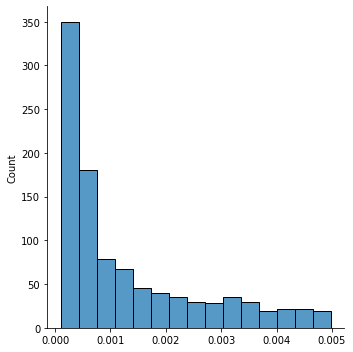

In [75]:
low = numpy.log(0.0001)
high = numpy.log(0.005)
sample_size = 1000
sample = numpy.exp(numpy.random.uniform(low, high, size=sample_size))
seaborn.displot(sample)

In [76]:
sample.max(), sample.min()

(0.004980610232365855, 0.00010016665752302445)